In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import seaborn as sns

# ECG processing
import wfdb
import neurokit2 as nk
from neurokit2 import ecg

# Import the 'os' library for operating system-related functions
import os
import tkinter as tk
from tkinter import ttk

# Import the 'pathlib' library for working with file paths
import pathlib
from collections import Counter

In [6]:
def analyze_ecg(singal,sampling_freq):
    cleaned = nk.ecg_clean(ecg, sampling_rate=sampling_freq)
    ecg, info=nk.ecg_process(cleaned)
    return

In [3]:
def plot_signal_with_annotation(signal, annotation_symbols, 
                                annotation_indices, sampling_freq, 
                                ann_style='r.', figsize=(15,6)):
    
    #create time axis
    time=np.arange(len(signal))/sampling_freq
    pvc_percentage=100*(Counter(annotation_symbols)['V']/Counter(annotation_symbols)['N'])
    pac_percentage=100*(Counter(annotation_symbols)['A']/Counter(annotation_symbols)['N'])
    
    plt.figure(figsize=figsize)
    plt.plot(time,signal)
    plt.xlabel("Time(s)")
    plt.xlim(0,time[-1]) 
    plt.ylabel("Amplitube (mV)")
    
    plt.text(0.5, -0.23,f"PVC Percentage:{pvc_percentage:.2f} \nPAC Percentage:{pac_percentage:.2f}",
             transform=plt.gca().transAxes, ha='center',fontsize=12)
    
    
    for idx, symbol in zip(annotation_indices, annotation_symbols):
        plt.plot(idx/sampling_freq, signal[idx], ann_style)
        plt.annotate(symbol, (idx/sampling_freq, signal[idx]), xytext=(4,5), textcoords='offset pixels')
    
    plt.legend('')
    plt.show()

In [9]:
def choose_ecg_record(folder_path):
    """
    Allows the user to choose an ECG file from the specified folder.

    Args:
        folder_path (str): Path to the folder containing ECG files.

    Returns:
        str: Selected ECG file name (without extension).
    """
    
    # List all files in the specified folder
    files = os.listdir(folder_path)
    # Create a list of base filenames (without the '.hea' extension) for ECG signal files
    hea_files = [f[:-4] for f in files if f.endswith(".hea")]
    
    # Create the main window
    root = tk.Tk()
    root.title("Select the ECG record")
    
    # Dropdown menu
    clicked = tk.StringVar()
    clicked.set("Select an ECG file")
    drop = ttk.Combobox(root, textvariable=clicked, values=hea_files)
    drop.pack()
    
    # Type time range
    tk.Label(root, text="Enter time range (s):").pack()
    time_from = tk.Entry(root)
    time_from.pack()
    time_to = tk.Entry(root)
    time_to.pack()
    
    def show():
        selected_file = clicked.get()
        label.config(text=f"Selected ECG file: {selected_file}")
        
        record = wfdb.rdrecord(os.path.join(folder_path, selected_file))
        sampling_frequency = record.fs
        samp_from = sampling_frequency * int(time_from.get())
        samp_to = samp_from + (int(time_to.get()) * sampling_frequency)
        
        physical_signal = record.p_signal[int(samp_from):int(samp_to), 0]
        
        annotation = wfdb.rdann(os.path.join(folder_path, selected_file), 'atr',
                                  sampfrom=samp_from, sampto=samp_to, shift_samps=True)
        symbol = annotation.symbol
        indices = annotation.sample
        
        plot_signal_with_annotation(signal=physical_signal,
                                    annotation_symbols=symbol,
                                    annotation_indices=indices,
                                    sampling_freq=sampling_frequency,
                                    ann_style='r.', figsize=(15,6))
        
        
    
    # Button to display the selected file
    button = tk.Button(root, text="Show Selected File", command=show)
    button.pack()

    # Label to display the selected file
    label = tk.Label(root, text="")
    label.pack()

    root.mainloop()

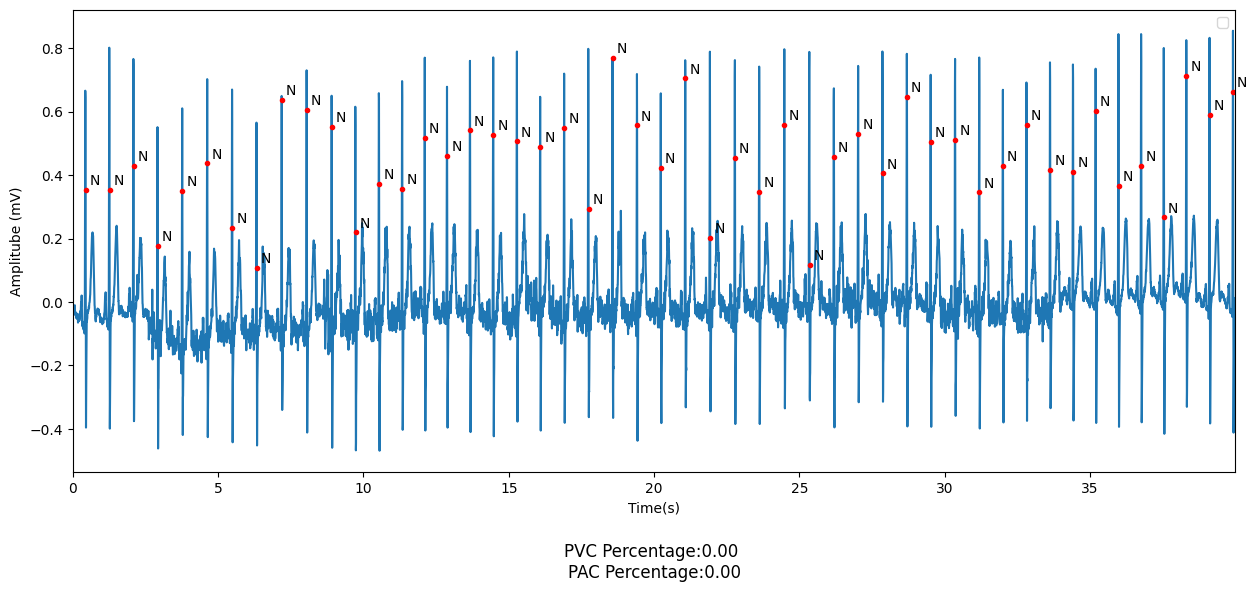

In [10]:
folder_path = "D:/CPSC2021/Training_set_I"
choose_ecg_record(folder_path)